# Development of miscellaneous new features for polymerist

## Fixing DOP calculation weirdness in polymer builder

In [7]:
from polymerist.polymers.building import build_linear_polymer, mbmol_to_openmm_pdb
from polymerist.polymers.monomers import MonomerGroup
from polymerist.polymers.monomers.specification import expanded_SMILES, compliant_mol_SMARTS

In [8]:
monogrp = MonomerGroup.from_file('poly(ethane-1,2-diol-co-furan-2,5-dicarboxylic acid).json')

In [9]:
from typing import TypeAlias

Smiles : TypeAlias = str
Smarts : TypeAlias = str

In [39]:
from rdkit import Chem

smiles_frags : dict[str, Smiles] = {
    'PEG_1A' : '[OH]CC*',
    'PEG_1B' : '*OCC[OH]',
    'PEG_2'  : '*OCC*',
    
    'PGA_1A' : '[OH]CC(=O)*',
    'PGA_1B' : '*OCC(=O)[OH]',
    'PGA_2'  : '*OCC(=O)*',
    
    'PLA_1A' : '[OH]C(C)C(=O)*',
    'PLA_1B' : '*OC(C)C(=O)[OH]',
    'PLA_2'  : '*OC(C)C(=O)*',
}

smarts_frags : dict[str, list[Smarts]] = {}
for name, smiles in smiles_frags.items():
    smiles_expl = expanded_SMILES(smiles)
    smarts = compliant_mol_SMARTS(smiles_expl)
    mol = Chem.MolFromSmarts(smiles_expl)
    smarts_frags[name] = smarts
    
    # print(name)
    # display(mol)
    # print('='*10)

In [40]:
monogrp = MonomerGroup(
    {name : [smarts] for name, smarts in smarts_frags.items()},
    # term_orient={'PEG_1A' : 'head', 'PEG_1B' : 'tail'}
)

PEG_1A


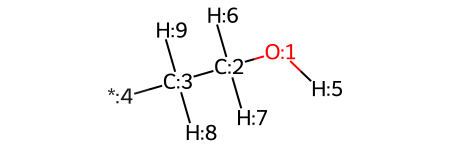

PEG_1B


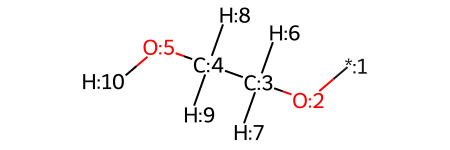

PEG_2


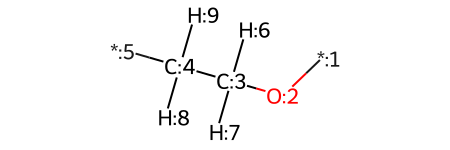

PGA_1A


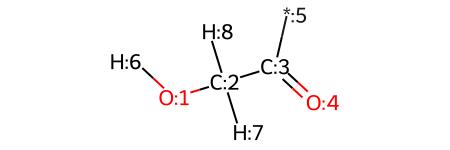

PGA_1B


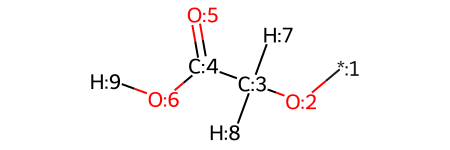

PGA_2


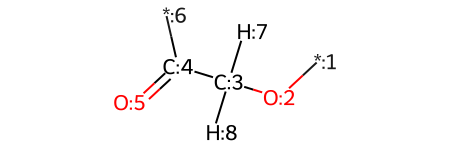

PLA_1A


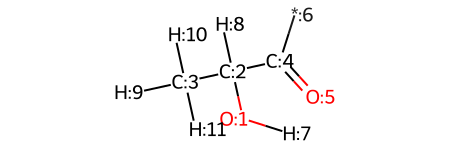

PLA_1B


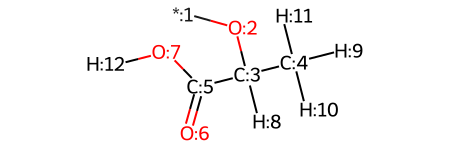

PLA_2


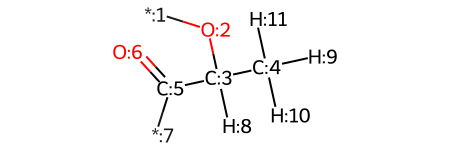

In [42]:
for name, mol in monogrp.iter_rdmols(term_only=None):
    print(name)
    display(mol)
    print('='*10)

In [44]:
chain = build_linear_polymer(monogrp, DOP=4, sequence='AB', energy_minimize=True)
mbmol_to_openmm_pdb('peg-plga.pdb', chain)

INFO:polymerist.polymers.building:Registering middle monomer PEG_2 (block identifier "A")
INFO:polymerist.polymers.building:Registering middle monomer PGA_2 (block identifier "B")
INFO:polymerist.polymers.building:Registering terminal monomer PEG_1A (orientation "head")
INFO:polymerist.polymers.building:Registering terminal monomer PEG_1B (orientation "tail")
INFO:polymerist.polymers.building:Assembling linear polymer chain with 4 monomers (53 atoms)
INFO:polymerist.polymers.building:Successfully assembled linear polymer chain with 4 monomers (53 atoms)
INFO:polymerist.polymers.building:Energy-minimizing chain to find more stabile conformer
INFO:polymerist.polymers.building:Energy minimization completed


## Testing polymerist importability within environment

In [ ]:
import numpy as np
from openff.toolkit import Molecule, Topology, ForceField

In [ ]:
import polymerist as ps
from polymerist.genutils import pyimports, importutils

import pandas as pd
print(importutils.module_hierarchy(ps))

In [ ]:
import nglview

print(nglview.__version__)
nglview.demo()

In [ ]:
from polymerist.polymers.monomers import specification
from rdkit import Chem

smi = 'CCO-c1ccccc1-N=C=C'
mol1 = Chem.MolFromSmiles(smi)
display(mol1)

sma = specification.expanded_SMILES(smi, assign_map_nums=True)
exp_sma = specification.compliant_mol_SMARTS(sma)
mol2 = Chem.MolFromSmarts(sma)
display(mol2)


In [ ]:
from openff.toolkit import Molecule

offmol = Molecule.from_smiles(smi)
offmol.generate_conformers(n_conformers=1)
offmol.visualize(backend='nglview')

# Parsing lines from PDB file

In [ ]:
l1 = 'ATOM    189  C99 OCT     5      39.590  30.100  38.320  1.00  0.00'           
l2 = 'ATOM    190 C100 OCT     5      38.850  31.110  37.700  1.00  0.00'
l3 = 'HETATM   47  H21 UNL     1       0.000   0.000   0.000  1.00  0.00           H '

In [ ]:
from typing import Any

PDB_ATOM_TOKEN_COLUMNS : dict[str, tuple[int, int]] = {
    'Is Heteratom' : (1, 6),
    'Atom serial number' : (7, 11),
    'Atom name' : (13, 16),
    'Alternate location indicator' : (17, 17),
    'Residue name' : (18, 20),
    'Chain identifier' : (22, 22),
    'Residue sequence number' : (23, 26),
    'Code for insertions of residues' : (27, 27),
    'X (angstrom)' : (31, 38),
    'Y (angstrom)' : (39, 46),
    'Z (angstrom)' : (47, 54),
    'Occupancy' : (55, 60),
    'Temperature factor' : (61, 66),
    'Segment identifier' : (73, 76),
    'Element symbol' : (77, 78),
    'Charge' : (79, 80),
} # taken from PDB spec doc (https://www.cgl.ucsf.edu/chimera/docs/UsersGuide/tutorials/pdbintro.html)
def tokenize_pdb_atom_line(line : str) -> dict[str, Any]:
    line = line.ljust(80, ' ') # pad line to 80 characters with spaces
    return {
        prop_name : line[i_start-1:i_end]
            for prop_name, (i_start, i_end) in PDB_ATOM_TOKEN_COLUMNS.items()
    }


for line in (l1, l2, l3):
    print(tokenize_pdb_atom_line(line))

# Another thing